# <a name="C0">Partie II. Segmentation clientèle : Essais<a>

**Importation des modules python**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import squarify
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import davies_bouldin_score,calinski_harabasz_score,silhouette_score

In [2]:
# Load the dataset
clustering_df = pd.read_csv("clustering_data.csv",index_col=0)
clustering_df.sample(10)

,customer_unique_id,customer_city,customer_state,order_purchase_timestamp,payment_value,review_score,product_category_name_english
29477,1a30d100192e3a5ad31164bf0dc90d9a,comendador levy gasparian,RJ,2017-05-06 20:23:57,55.00,5.0,fashion_bags_accessories
52489,7d6aacf8eb406bd16f8cca2be7163c75,praia grande,SP,2017-11-06 14:37:30,265.68,5.0,computers_accessories
11002,ab0b362001c351ac0abb5cca5820b3e2,sao paulo,SP,2018-01-10 10:54:38,65.00,2.0,perfumery
57816,68df5ae3292acfde45e8071437a920b9,santa ines,BA,2018-02-27 13:00:35,70.82,5.0,furniture_decor
20337,db094faaa9628ba9f5e5da127407f139,alcinopolis,MS,2018-06-26 16:44:39,38.04,5.0,bed_bath_table
36069,3a3820686adb2b0db7825eff823c51f1,sao paulo,SP,2018-04-22 15:36:47,313.53,1.0,bed_bath_table
4473,39e2788db03e5eaeb2935a7e479682c6,cacapava,SP,2018-03-27 19:23:42,249.94,4.0,housewares
39011,33730ab0c9a5aaa572c85eb7f07dd357,brasilia,DF,2018-05-14 08:42:15,159.63,5.0,electronics
64368,661e47af64e226f008685d742e52c2a4,patos de minas,MG,2018-03-19 10:39:22,58.32,3.0,housewares
41680,01413c132b54b9b7dfadc2ee71ef78c8,sao bento do una,PE,2017-11-08 19:05:31,51.69,1.0,housewares


In [3]:
# Convert date column to datetime
clustering_df["order_purchase_timestamp"] = pd.to_datetime(clustering_df["order_purchase_timestamp"],
                                                           format="%Y-%m-%d %H:%M:%S")

In [4]:
clustering_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67023 entries, 0 to 67022
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_unique_id             67023 non-null  object        
 1   customer_city                  67023 non-null  object        
 2   customer_state                 67023 non-null  object        
 3   order_purchase_timestamp       67023 non-null  datetime64[ns]
 4   payment_value                  67023 non-null  float64       
 5   review_score                   67023 non-null  float64       
 6   product_category_name_english  67023 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 4.1+ MB


# Segmentation des clients

## 1. Segmentation RFM 

**Création d'un dataframe RFM**

RFM : segmenter les clients en fonction de leur comportement d'achat.
- Récence : elle permet de situer le dernier achat dans le temps. 
- Fréquence : elle indique le nombre de fois où le client a fait une transaction pendant une période donnée.
- Montant : elle correspond à la somme ou moyenne des dépenses du client.

Columns importantes pour l'analyse RFM :
- Récence : order_purchase_timestamp
- Fréquence : customer_unique_id
- Montant : payment_value

In [5]:
# Period of orders
print(f"Période de commandes : du {clustering_df['order_purchase_timestamp'].min()} au {clustering_df['order_purchase_timestamp'].max()}")

Période de commandes : du 2016-10-03 09:44:50 au 2018-08-29 15:00:37


- **Exploration du jeu de données RFM.**

In [8]:
# Categorical columns 
cat_cols = clustering_df.select_dtypes(include='object')

# Important columns for RFM analysis  
rfm_df = clustering_df[["customer_unique_id","order_purchase_timestamp","payment_value","review_score"]]

# RFM Dataframe
rfm_df = rfm_df.groupby("customer_unique_id").agg({"order_purchase_timestamp": "max",
                                                     "payment_value": "mean","customer_unique_id": "count",
                                                     "review_score": "mean"})

rfm_df = rfm_df.rename(columns={"customer_unique_id": "Frequency","payment_value":"Montant",
                                 "review_score": "mean_review_score"}).reset_index()

# Create the Recency column from order_purchase_timestamp
rfm_df["Recency"] = (rfm_df["order_purchase_timestamp"].max() - rfm_df['order_purchase_timestamp']).dt.days

# Joining with the main dataset
customer_df = pd.merge(rfm_df, cat_cols, how = "left", on = "customer_unique_id")
# droping duplicated lines
customer_df = customer_df.drop_duplicates(subset=["customer_unique_id"]).reset_index(drop=True)
rfm_df.drop("mean_review_score",axis=1,inplace=True)

customer_df.sample(10)

,customer_unique_id,order_purchase_timestamp,Montant,Frequency,mean_review_score,Recency,customer_city,customer_state,product_category_name_english
18279,478d38d8da5b73c1ec69b8d141aca8e2,2018-04-13 22:10:25,551.15,1,5.0,137,brasilia,DF,books_general_interest
44387,ae0b2ed66af9ee82a19ef3b6a3cf4e7c,2017-03-23 22:09:52,45.86,1,5.0,523,boituva,SP,garden_tools
25953,655e94487e6c8fc38d9221ff9aac4cf3,2017-11-25 12:00:25,257.82,1,5.0,277,suzano,SP,watches_gifts
44111,acfd5b41bfa4969ecacc00a7cb8dafc8,2017-11-26 17:40:04,30.00,1,5.0,275,sao paulo,SP,furniture_decor
22419,578a97bb13e088306095bd0401426700,2018-04-23 20:35:55,64.03,1,3.0,127,sao paulo,SP,garden_tools
7301,1c634267830730a9acab5e198fd500c6,2017-10-16 15:04:24,84.05,1,5.0,316,quirinopolis,GO,fashion_shoes
28191,6e461ec96c9aad81128aca921cfe901d,2018-03-19 17:53:52,31.99,1,5.0,162,santo andre,SP,electronics
37000,917973917330d733f54ebca92bb47001,2017-08-21 16:30:00,106.97,1,4.0,372,lauro de freitas,BA,perfumery
24405,5f435bbe57e905e19378fa56b60e9d16,2018-01-04 14:16:56,75.97,2,3.0,237,itatiaia,RJ,electronics
52702,cecd5e9d39fddb69384c1c31bdfac666,2018-07-16 19:03:10,118.35,1,5.0,43,sao paulo,SP,health_beauty


In [9]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65129 entries, 0 to 65128
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_unique_id             65129 non-null  object        
 1   order_purchase_timestamp       65129 non-null  datetime64[ns]
 2   Montant                        65129 non-null  float64       
 3   Frequency                      65129 non-null  int64         
 4   mean_review_score              65129 non-null  float64       
 5   Recency                        65129 non-null  int64         
 6   customer_city                  65129 non-null  object        
 7   customer_state                 65129 non-null  object        
 8   product_category_name_english  65129 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 4.5+ MB


In [10]:
rfm_df

,customer_unique_id,order_purchase_timestamp,Montant,Frequency,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,141.90,1,111
1,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,86.22,1,536
2,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,43.62,1,320
3,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,196.89,1,287
4,0004bd2a26a76fe21f786e4fbd80607f,2018-04-05 19:33:16,166.98,1,145
...,...,...,...,...,...
65124,fff96bc586f78b1f070da28c4977e810,2018-08-15 10:26:57,63.42,1,14
65125,fffb09418989a0dbff854a28163e47c6,2017-12-17 19:14:35,73.16,1,254
65126,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,84.58,1,261
65127,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,133.69,1,118


In [11]:
# RFM Dataframe
rfm_df[["Recency","Montant","Frequency"]].describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,65129.0,235.454698,152.535386,0.00,112.00,217.00,345.00,694.00
Montant,65129.0,155.552707,210.332842,10.07,60.59,100.67,171.44,6929.31
Frequency,65129.0,1.029081,0.209589,1.00,1.00,1.00,1.00,11.00


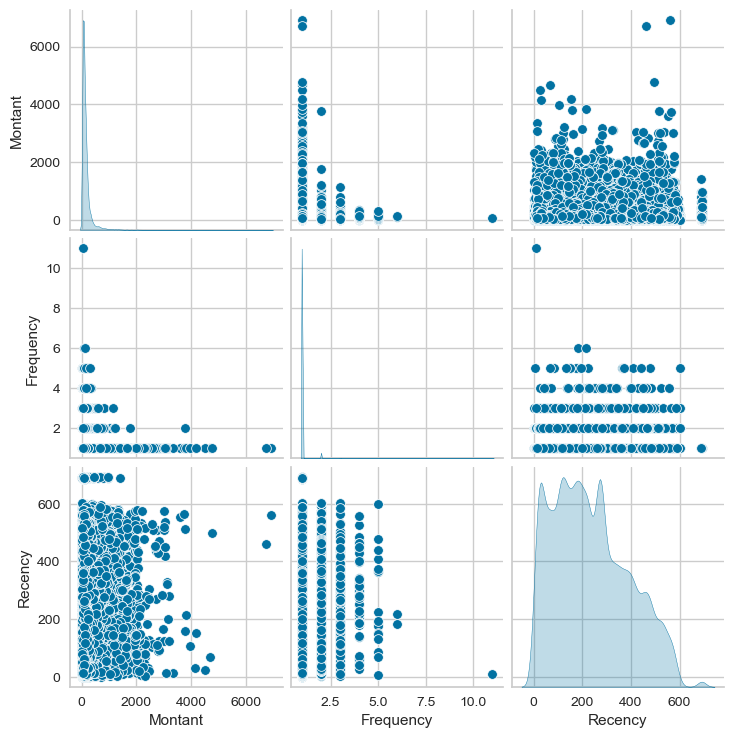

In [12]:
# Pair plotting
sns.pairplot(rfm_df,diag_kind="kde")
plt.show()

- **Il n'y a pas de liens linéaires évidents entre les variables RFM.** 

### **Scores RFM**

In [13]:
# Recency decsription
rfm_df["Recency"].describe()

count    65129.000000
mean       235.454698
std        152.535386
min          0.000000
25%        112.000000
50%        217.000000
75%        345.000000
max        694.000000
Name: Recency, dtype: float64

In [14]:
# Recency quartiles (Q2)
rfm_df.loc[(rfm_df["Recency"]>112)&(rfm_df["Recency"]<=217)].count()

customer_unique_id          16365
order_purchase_timestamp    16365
Montant                     16365
Frequency                   16365
Recency                     16365
dtype: int64

In [15]:
# Recency quartiles (Q4)
rfm_df.loc[(rfm_df["Recency"]>345)].count()

customer_unique_id          16199
order_purchase_timestamp    16199
Montant                     16199
Frequency                   16199
Recency                     16199
dtype: int64

In [16]:
# Recency scoring
pd.qcut(rfm_df["Recency"],q=4,labels=[1, 2, 3, 4]).value_counts()

2    16365
1    16357
3    16208
4    16199
Name: Recency, dtype: int64

In [17]:
# Frequency 
rfm_df["Frequency"].value_counts()

1     63594
2      1277
3       185
4        53
5        17
6         2
11        1
Name: Frequency, dtype: int64

In [18]:
# Frequency description 
rfm_df["Frequency"].describe()

count    65129.000000
mean         1.029081
std          0.209589
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         11.000000
Name: Frequency, dtype: float64

In [19]:
rfm_df["Frequency"].apply(lambda x: "1" if x == 1 else "2").value_counts()

1    63594
2     1535
Name: Frequency, dtype: int64

In [20]:
# Montant description
rfm_df["Montant"].describe()

count    65129.000000
mean       155.552707
std        210.332842
min         10.070000
25%         60.590000
50%        100.670000
75%        171.440000
max       6929.310000
Name: Montant, dtype: float64

In [21]:
# Montant quartiles (Q1)
rfm_df.loc[(rfm_df["Montant"]<=61.280000)].count()

customer_unique_id          16587
order_purchase_timestamp    16587
Montant                     16587
Frequency                   16587
Recency                     16587
dtype: int64

In [22]:
# Montant quartiles (Q3)
rfm_df.loc[(rfm_df["Montant"]>102.7)&(rfm_df["Montant"]<=175.25)].count()

customer_unique_id          16317
order_purchase_timestamp    16317
Montant                     16317
Frequency                   16317
Recency                     16317
dtype: int64

In [23]:
# Montant scoring
pd.qcut(rfm_df["Montant"],q=4,labels=[1, 2, 3, 4]).value_counts()

1    16284
3    16284
2    16283
4    16278
Name: Montant, dtype: int64

In [24]:
# RFM scoring

# Recency score
rfm_df["Recency_score"]  = pd.qcut(rfm_df["Recency"],q=4,labels=[1, 2, 3, 4])

# Frequence score
rfm_df["Frequency_score"]= rfm_df["Frequency"].apply(lambda x: "1" if x == 1 else "2")

# Montant score
rfm_df["Montant_score"] = pd.qcut(rfm_df["Montant"],q=4,labels=[1, 2, 3, 4])

# Score RFM
rfm_df["rfm_score"] = rfm_df.apply(lambda x:str(x["Recency_score"])+str(x["Frequency_score"])
                                     +str(x["Montant_score"]),axis=1)

rfm_df

,customer_unique_id,order_purchase_timestamp,Montant,Frequency,Recency,Recency_score,Frequency_score,Montant_score,rfm_score
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,141.90,1,111,1,1,3,113
1,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,86.22,1,536,4,1,2,412
2,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,43.62,1,320,3,1,1,311
3,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,196.89,1,287,3,1,4,314
4,0004bd2a26a76fe21f786e4fbd80607f,2018-04-05 19:33:16,166.98,1,145,2,1,3,213
...,...,...,...,...,...,...,...,...,...
65124,fff96bc586f78b1f070da28c4977e810,2018-08-15 10:26:57,63.42,1,14,1,1,2,112
65125,fffb09418989a0dbff854a28163e47c6,2017-12-17 19:14:35,73.16,1,254,3,1,2,312
65126,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,84.58,1,261,3,1,2,312
65127,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,133.69,1,118,2,1,3,213


In [26]:
# Define the function to get the rfm segments
def rfm_segments(rfm):
    if rfm in ["124","224","114"]: 
        return "Champions"
    
    elif rfm in ["123","223","113","213","214"]:
        return "Loyaux"
    
    elif rfm in ["111","112"]:
        return "Nouveaux clients"
    
    elif rfm in ["121","211","212","221","222","122"]:
        return "Loyalistes potentiels"
    
    elif rfm in ["414","423","424","314","323","324"] :
        return "A réactiver"
    
    elif rfm in ["411","412","413","421","422","311","312","313","321","322"]:
        return "Perdus"


rfm_df["rfm_segment"] = rfm_df["rfm_score"].apply(rfm_segments)

rfm_df

,customer_unique_id,order_purchase_timestamp,Montant,Frequency,Recency,Recency_score,Frequency_score,Montant_score,rfm_score,rfm_segment
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,141.90,1,111,1,1,3,113,Loyaux
1,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,86.22,1,536,4,1,2,412,Perdus
2,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,43.62,1,320,3,1,1,311,Perdus
3,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,196.89,1,287,3,1,4,314,A réactiver
4,0004bd2a26a76fe21f786e4fbd80607f,2018-04-05 19:33:16,166.98,1,145,2,1,3,213,Loyaux
...,...,...,...,...,...,...,...,...,...,...
65124,fff96bc586f78b1f070da28c4977e810,2018-08-15 10:26:57,63.42,1,14,1,1,2,112,Nouveaux clients
65125,fffb09418989a0dbff854a28163e47c6,2017-12-17 19:14:35,73.16,1,254,3,1,2,312,Perdus
65126,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,84.58,1,261,3,1,2,312,Perdus
65127,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,133.69,1,118,2,1,3,213,Loyaux


- Clients champions : Ils correspondent aux clients qui dépensent le plus et qui ne sont pas perdus de vus.
- Client perdus : Ils correspondent aux clients qui ont peu dépensé et qui n'ont plus commandé depuis longtemps.

**Représentation graphique des résultats de la segementation RFM**

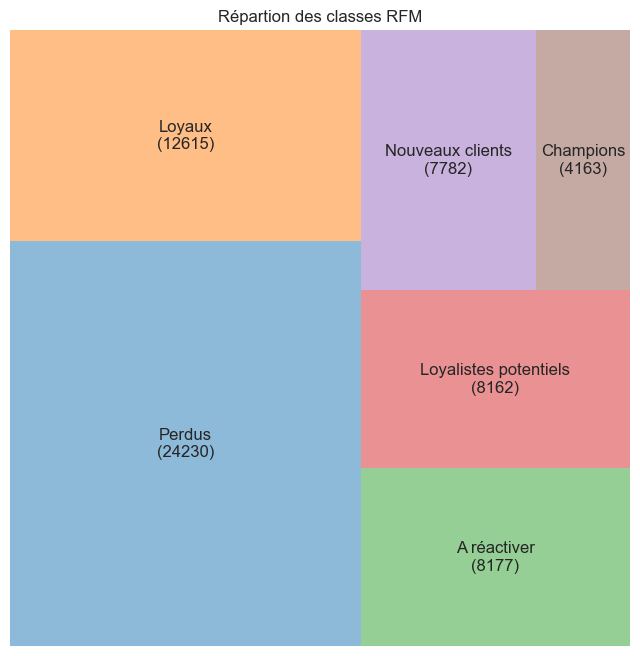

In [28]:
# Treemap of the RFM segments
plt.figure(figsize=(8,8))
rfm_treemap_df = rfm_df.rfm_segment.value_counts().reset_index().rename(columns={"index":"rfm_segment",
                                                                                 "rfm_segment":"nb_customers"})

labels = []
for i in range(0,len(rfm_treemap_df)):
    labels.append(f"{rfm_treemap_df.rfm_segment[i]}\n({rfm_treemap_df.nb_customers[i]})")

squarify.plot(sizes=rfm_treemap_df['nb_customers'],label=labels,alpha=.5,color=sns.color_palette(palette="tab10"))
plt.axis("off") 
plt.title("Répartion des classes RFM")
plt.show()

**Interprétation**

- À partir de la grille des segments de clientèle ci-dessus, on peut voir que les clients champions constituent le plus petit segment par rapport aux autres segments, tandis que les segments les plus importants sont celui des clients perdus et celui des clients loyaux. Il serait donc judicieux de mener une stratégie visant à conserver les clients loyeux et de faire en sorte que les clients perdus reviennent et fassent à nouveau des achats chez Olist.

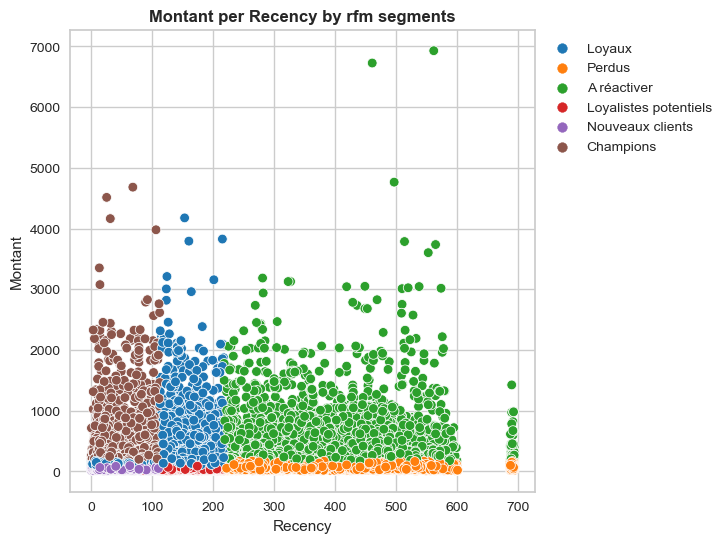

In [33]:
# Scatter plot of rfm groups
plt.figure(figsize=(6,6))
sns.scatterplot(data=rfm_df,y="Montant",x="Recency",hue="rfm_segment",palette="tab10")
plt.title("Montant per Recency by rfm segments",fontweight="bold")
plt.legend(bbox_to_anchor=(1,1),loc="best")
plt.show()

**Interprétation**

- On voit mieux la répartition des groupes RFM via ce nuage de points entre les variables Récence et Montant.
- Pour les clients à réactiver, Olist doit les cibler avec des mails de reprise de contact en leur proposant par exemple des réductions dans leurs futures commandes s'ils reviennent.
- Pour les nouveaux clients, Olist doit planifier des offres de fidélisation comme leur proposer des promotions attrayantes afin qu'ils continuent à utiliser les services d'Olist et puissent devenir de clients loyaux.

## 2. Segmentation client avec les algorithmes de clustering

**Jeu de données pour le clustering**

In [34]:
# Création du datframe de segmentation RFM avec K-Means
df_clustering = rfm_df.copy()
df_clustering

,customer_unique_id,order_purchase_timestamp,Montant,Frequency,Recency,Recency_score,Frequency_score,Montant_score,rfm_score,rfm_segment
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,141.90,1,111,1,1,3,113,Loyaux
1,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,86.22,1,536,4,1,2,412,Perdus
2,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,43.62,1,320,3,1,1,311,Perdus
3,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,196.89,1,287,3,1,4,314,A réactiver
4,0004bd2a26a76fe21f786e4fbd80607f,2018-04-05 19:33:16,166.98,1,145,2,1,3,213,Loyaux
...,...,...,...,...,...,...,...,...,...,...
65124,fff96bc586f78b1f070da28c4977e810,2018-08-15 10:26:57,63.42,1,14,1,1,2,112,Nouveaux clients
65125,fffb09418989a0dbff854a28163e47c6,2017-12-17 19:14:35,73.16,1,254,3,1,2,312,Perdus
65126,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,84.58,1,261,3,1,2,312,Perdus
65127,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,133.69,1,118,2,1,3,213,Loyaux


In [35]:
# Description
df_clustering[["Recency","Frequency","Montant"]].describe()

,Recency,Frequency,Montant
count,65129.000000,65129.000000,65129.000000
mean,235.454698,1.029081,155.552707
std,152.535386,0.209589,210.332842
min,0.000000,1.000000,10.070000
25%,112.000000,1.000000,60.590000
50%,217.000000,1.000000,100.670000
75%,345.000000,1.000000,171.440000
max,694.000000,11.000000,6929.310000


- la fréquence est quasiment invariable, sa présence donc peut biaiser le résultat du clustering, nous la supprimons et nous gardons uniquement les variables de récence et de montant.

In [36]:
# Joining with the main dataset
clustering_data = pd.merge(df_clustering,customer_df,how ="left",on="customer_unique_id")
clustering_data = clustering_data.rename(columns={"order_purchase_timestamp_x":"order_purchase_timestamp","Montant_x":"Montant",
                       "Frequency_x":"Frequency","Recency_x":"Recency",})
clustering_data = clustering_data[["Recency","Montant","mean_review_score"]]
clustering_data

,Recency,Montant,mean_review_score
0,111,141.90,5.0
1,536,86.22,3.0
2,320,43.62,4.0
3,287,196.89,5.0
4,145,166.98,4.0
...,...,...,...
65124,14,63.42,4.0
65125,254,73.16,5.0
65126,261,84.58,4.0
65127,118,133.69,5.0


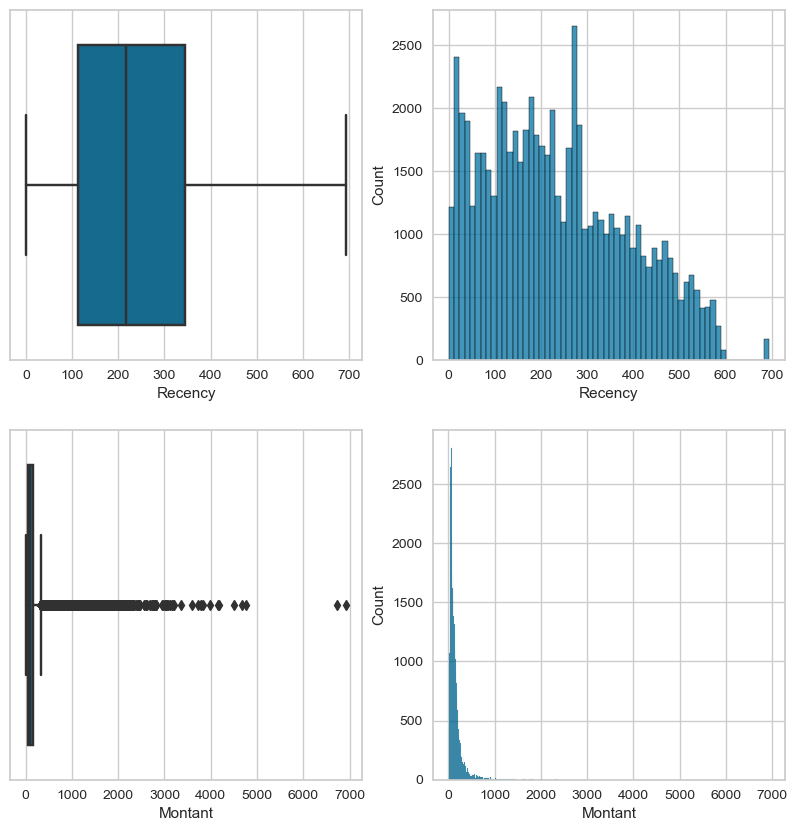

In [37]:
# fig, axes = plt.subplots(2, 2,figsize=(20,20))
plt.figure(figsize=(10,10))
nb_cols = len(clustering_data[["Recency","Montant"]].columns)
for i in range(0,nb_cols):
    plt.subplot(nb_cols,2,2*i+1)
    sns.boxplot(x=clustering_data[["Recency","Montant"]].iloc[:,i])
    plt.subplot(nb_cols,2,2*(i+1))
    sns.histplot(x=clustering_data[["Recency","Montant"]].iloc[:,i])
plt.show()

In [38]:
# Transform the montant values into logarithms so that each variable has the same weight
cols= ["Montant"]
cols_preprocessed = clustering_data[cols].apply(np.log1p, axis=1)
log_clustering_data = clustering_data.copy()
log_clustering_data.loc[:,cols] = log_clustering_data[cols].apply(np.log1p, axis=1)
log_clustering_data

,Recency,Montant,mean_review_score
0,111,4.962145,5.0
1,536,4.468434,3.0
2,320,3.798182,4.0
3,287,5.287711,5.0
4,145,5.123845,4.0
...,...,...,...
65124,14,4.165424,4.0
65125,254,4.306225,5.0
65126,261,4.449452,4.0
65127,118,4.902976,5.0


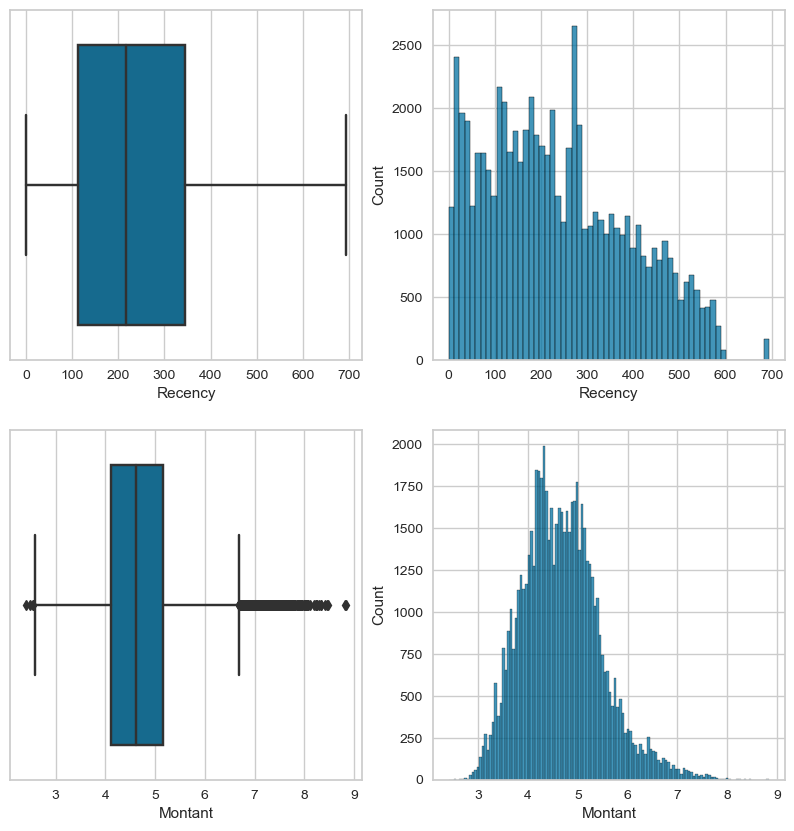

In [39]:
# 
plt.figure(figsize=(10,10))
cols= ["Recency","Montant"]
nb_cols = len(log_clustering_data[cols].columns)
for i in range(0,nb_cols):
    plt.subplot(nb_cols,2,2*i+1)
    sns.boxplot(x=log_clustering_data[cols].iloc[:,i])
    plt.subplot(nb_cols,2,2*(i+1))
    sns.histplot(x=log_clustering_data[cols].iloc[:,i])
plt.show()

In [40]:
log_clustering_data

,Recency,Montant,mean_review_score
0,111,4.962145,5.0
1,536,4.468434,3.0
2,320,3.798182,4.0
3,287,5.287711,5.0
4,145,5.123845,4.0
...,...,...,...
65124,14,4.165424,4.0
65125,254,4.306225,5.0
65126,261,4.449452,4.0
65127,118,4.902976,5.0


### **Standardistaion des données**

In [42]:
# Standardization 
scaler = StandardScaler()
cols_scaled = scaler.fit_transform(log_clustering_data)

# Scaled dataframe
X_scaled = pd.DataFrame(cols_scaled,index=log_clustering_data.index,columns=log_clustering_data.columns)
X_scaled

,Recency,Montant,mean_review_score
0,-0.815913,0.361815,0.641369
1,1.970347,-0.256897,-0.990102
2,0.554271,-1.096845,-0.174366
3,0.337926,0.769809,0.641369
4,-0.593013,0.564455,-0.174366
...,...,...,...
65124,-1.451836,-0.636624,-0.174366
65125,0.121581,-0.460174,0.641369
65126,0.167473,-0.280685,-0.174366
65127,-0.770022,0.287665,0.641369


## 2.1. Segmentation clients avec KMeans

> Le principe de la segmentation KMeans est de choisir à l'avance un nombre de clusters k. On choisit aléatoirement k centroides puis on associe à chaque point le cluster le plus proche. On re-calcule les centroides et contrôle à nouveau l'appartenance des points aux clusters. On répète le processus jusqu'à ce que les clusters soient stables(i.e ne bougent plus).

**Recherche du meilleur paramètre K pour l'algorithme KMeans à l'aide de Yellowbricks**

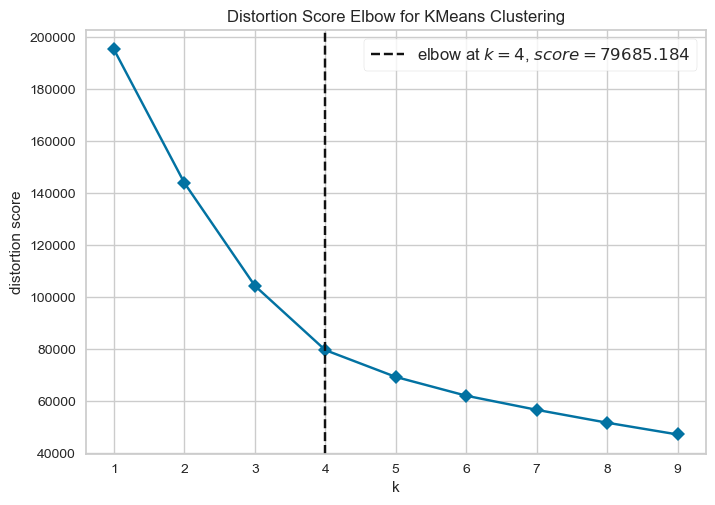

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [43]:
# Searching optimal K parameter in the clustering metric with Yellowbrick

# Instantiate the clustering model and visualizer  
kmeans_model = KMeans(init="k-means++",random_state=42)

# KElbowVisualizer visualizes the clusters according to a scoring function, looking for an "elbow" in the curve.
elbow1 = KElbowVisualizer(kmeans_model, k=(1, 10),timings=False)

# Training and plotting the distorsion embow model
elbow1.fit(X_scaled)
elbow1.show()

**Silhouette score :**

L'analyse de silhouette peut être utilisée pour évaluer la densité et la séparation entre les clusters. Le score est calculé en faisant la moyenne du coefficient de silhouette pour chaque échantillon, qui est calculé comme la différence entre la distance intra-cluster moyenne et la distance moyenne du cluster le plus proche pour chaque échantillon, normalisée par la valeur maximale. Cela produit un score compris entre -1 et +1, où les scores proches de +1 indiquent une séparation élevée et les scores proches de -1 indiquent que les échantillons ont peut-être été assignés au mauvais cluster.

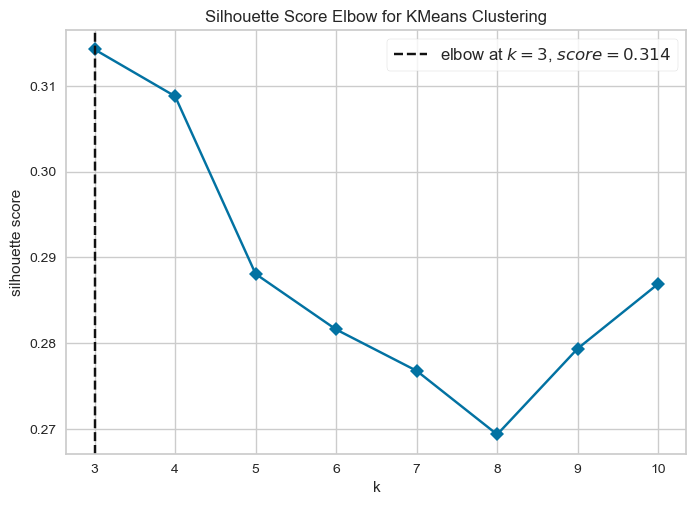

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [44]:
# Instantiate the clustering model and visualizer  
kmeans_model = KMeans(init="k-means++",random_state=42)

# KElbowVisualizer visualizes the clusters according to a scoring function, looking for an "elbow" in the curve.
elbow2 = KElbowVisualizer(kmeans_model, k=(3, 11),metric="silhouette",timings=False)

# Training and plotting the distorsion embow model
elbow2.fit(X_scaled)
elbow2.show()

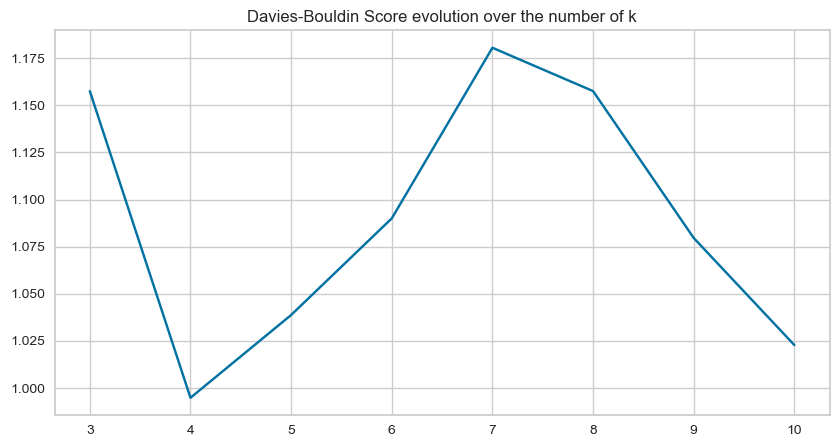

In [45]:
dict_kmeans = {}

for k in range(3,11):
    model_kmeans = KMeans(n_clusters=k,init="k-means++",random_state=42).fit(X_scaled)
    dict_kmeans[k] = model_kmeans


davies_bouldin_kmeans = {}
for i in range(3, 11):
    davies_bouldin_kmeans[i] = davies_bouldin_score(X=X_scaled,labels=list(dict_kmeans[i].labels_))
    
plt.figure(figsize=(10,5))
plt.title("Davies-Bouldin Score evolution over the number of k")
sns.lineplot(x=list(davies_bouldin_kmeans.keys()),y=list(davies_bouldin_kmeans.values()))
plt.show()

- l'indice de Davies-Bouldin est une mesure de qualité d'une partition d'un ensemble de données

**Choix du nombre k de clusters**
- Basé sur le score de distorsion issu de la méthode des coudes, 4 semble être le bon nombre de clusters.
- Le score silhouette est maximal pour 3 clusters (score = 0.314).
- Le score Davies-Bouldin est minimal pour 4 clusters.

Le nombre optimal de clusters est donc entre 3 et 4. Testons donc des modèles de KMeans avec k=3 et k=4.

### **2.1.1. KMeans avec 3 clusters**

In [46]:
# Instantiate the clustering model and visualizer 
kmeans_model1 = KMeans(3,init="k-means++",random_state=42)
kmeans_model1.fit_predict(X_scaled)

array([2, 0, 0, ..., 0, 2, 0])

In [47]:
# KMeans clusters
np.unique(kmeans_model1.labels_)

array([0, 1, 2])

In [50]:
# Make cluster column
kmeans_labels1 = kmeans_model1.labels_
kmeans_df1 = clustering_data.copy()
kmeans_df1["Cluster"] = kmeans_labels1

# centroids' caracteristics
kmeans_df1.groupby("Cluster").mean()

,Recency,Montant,mean_review_score
Cluster,,,
0,389.921984,153.387419,4.645626
1,227.354893,166.308591,1.823107
2,120.504363,153.438596,4.721309


In [51]:
# median's caracteristics
kmeans_df1.groupby("Cluster").median()

,Recency,Montant,mean_review_score
Cluster,,,
0,379.0,96.02,5.0
1,205.0,105.38,1.0
2,118.0,102.53,5.0


<Figure size 1000x500 with 0 Axes>

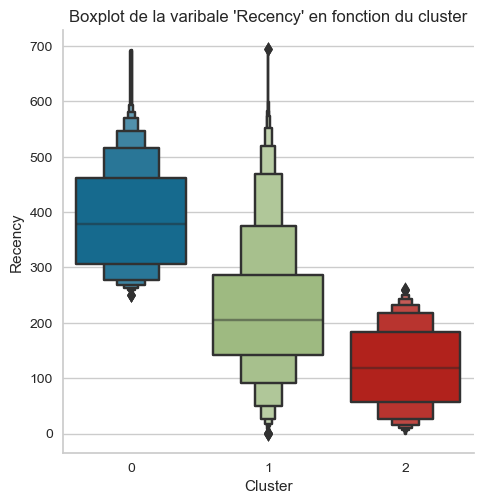

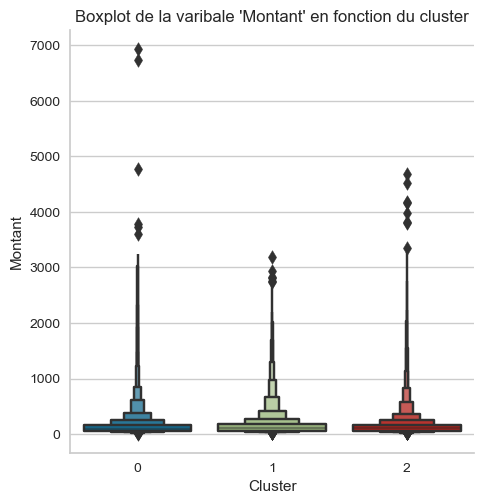

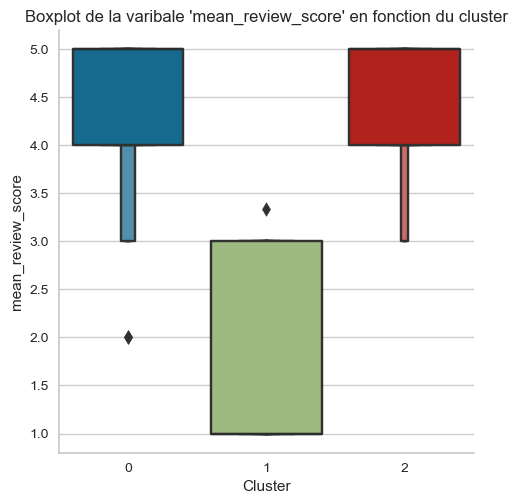

In [59]:
# Boxplot des features par cluster
plt.figure(figsize=(10, 5))
for column in kmeans_df1.columns[:-1]:
    plot = sns.catplot(x="Cluster",y=column,data=kmeans_df1,kind='boxen')
    plot.set(title = f"Boxplot de la varibale '{column}' en fonction du cluster")
    
plt.show()

- Classe 0 : La classe 0 correspond en moyenne à des clients qui n'ont pas commandé depuis très longtemps mais qui notes bien les commandes. Elle correspond à la classe des clients à réactiver.
- Classe 1 : La classe 1 correspond en moyenne à des clients qui n'ont pas commandé depuis relativement longtemps, qui ont beaucoup dépensé mais notent assez mal leurs commandes. Cette classe semble assez contradictoire. 
- Classe 2 : La classe 2 correspond en moyenne à la classe de clients qui ont commandé recemment, qui ont beaucoup dépensé et notent bien les commandes. Elle semble correspondre à la classe des clients loyaux.

**Métriques de performance du modèle**

In [53]:
# Metrics 

# Davies Bouldin index : The minimum score is zero, with lower values indicating better clustering.
kmeans_davies_bouldin1 = davies_bouldin_score(X_scaled, kmeans_labels1)
# alinski_harabasz : 
kmeans_calinski_harabasz1 = calinski_harabasz_score(X_scaled, kmeans_labels1)
# silhouette : 
kmeans_silhouette1 = silhouette_score(X_scaled, kmeans_model.fit_predict(X_scaled))

kmean_list1 = [kmeans_davies_bouldin1,kmeans_calinski_harabasz1,kmeans_silhouette1]
tableau = np.array([kmean_list1])
model_liste = [type(kmeans_model1).__name__]
pd.DataFrame(tableau,model_liste,columns=["davies_bouldin index",
                                          "calinski_harabasz","silhouette_score"]).sort_values(by="silhouette_score")

,davies_bouldin index,calinski_harabasz,silhouette_score
KMeans,1.157556,28360.758141,0.286921


**Ce clustering semble assez contradictoire avec des classes qui dépensent presque de la même façon et dont les notations des commandent se contredisent.**

### **2.1.2. KMeans avec 4 clusters**

In [60]:
# Instantiate the clustering model 
kmeans_model2 = KMeans(4,init="k-means++",random_state=42)
kmeans_model2.fit_predict(X_scaled)

array([3, 0, 0, ..., 1, 3, 0])

In [61]:
# KMeans clusters
np.unique(kmeans_model2.labels_)

array([0, 1, 2, 3])

In [64]:
# Make cluster column
kmeans_labels2 = kmeans_model2.labels_
kmeans_df2 = clustering_data.copy()
kmeans_df2["Cluster"] = kmeans_labels2

# centroids' caracteristics
kmeans_df2.groupby("Cluster").mean()

,Recency,Montant,mean_review_score
Cluster,,,
0,421.559379,111.674373,4.607041
1,138.247886,66.984588,4.656266
2,233.717736,157.891441,1.633977
3,169.664418,316.878178,4.660296


In [65]:
# median's caracteristics
kmeans_df2.groupby("Cluster").median()

,Recency,Montant,mean_review_score
Cluster,,,
0,414.0,88.08,5.0
1,133.0,64.09,5.0
2,215.0,107.50,1.0
3,160.0,207.61,5.0


<Figure size 1000x500 with 0 Axes>

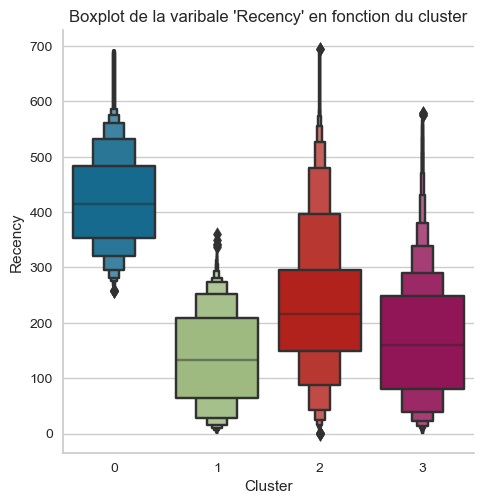

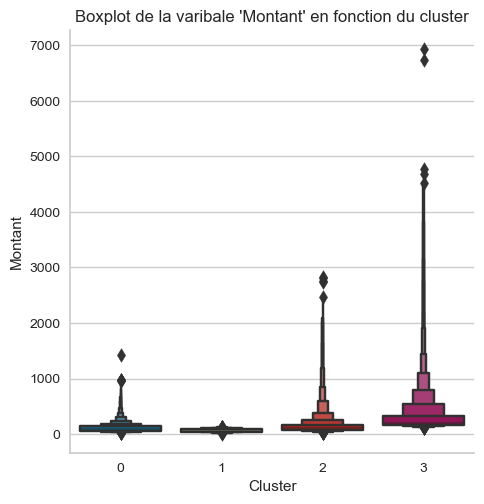

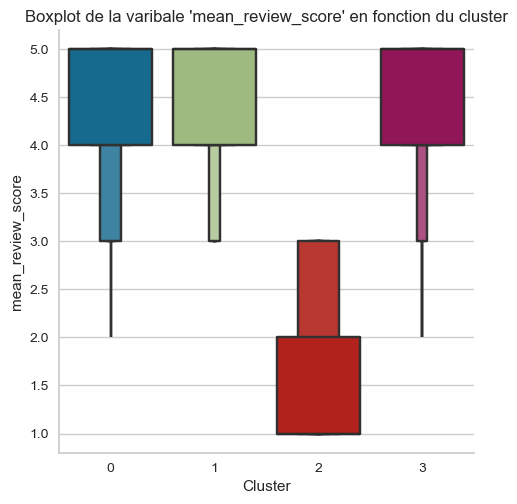

In [73]:
# Boxplot des features par cluster
plt.figure(figsize=(10, 5))
for column in kmeans_df2.columns[:-1]:
    plot = sns.catplot(x="Cluster",y=column,data=kmeans_df2,kind='boxen')
    plot.set(title = f"Boxplot de la varibale '{column}' en fonction du cluster")
    
plt.show()

**Interprétation :**
- Classe 0 : La classe 0 correspond en moyenne à des clients qui n'ont pas commandé depuis très longtemps, qui dépensent raisonnablement et qui notent bien les commandes. Elle correspond à la classe des clients à réactiver.
<br>
<br>
- Classe 1 : La classe 1 correspond en moyenne à des clients qui ont commandé récemment, qui ont peu dépensé et qui notent bien les commandes. Elle correspond à la classe des clients loyalistes potentiels et des nouveaux clients.
<br>
<br>
- Classe 2 : La classe 2 correspond en moyenne à des clients qui n'ont pas commandé depuis longtemps, qui ont dépensé raisonnablement mais qui notent très mal les commandes. Elle correspond à la classe des clients perdus.
<br>
<br>
- Classe 3 : La classe 3 correspond en moyenne à des clients qui ont commandé récemment, qui ont beaucoup dépensé et qui notent très bien les commandes. Elle correspond à la classe des clients loyaux et les champions.

**Métriques de performance du modèle**

In [67]:
# Metrics 

# Davies Bouldin index : The minimum score is zero, with lower values indicating better clustering.
kmeans_davies_bouldin2 = davies_bouldin_score(X_scaled, kmeans_labels2)
# alinski_harabasz : 
kmeans_calinski_harabasz2 = calinski_harabasz_score(X_scaled, kmeans_labels2)
# silhouette : 
kmeans_silhouette2 = silhouette_score(X_scaled, kmeans_model.fit_predict(X_scaled))

kmean_list2 = [kmeans_davies_bouldin2,kmeans_calinski_harabasz2,kmeans_silhouette2]
tableau = np.array([kmean_list2])
model_liste = [type(kmeans_model2).__name__]
pd.DataFrame(tableau,model_liste,columns=["davies_bouldin index",
                                          "calinski_harabasz","silhouette_score"]).sort_values(by="silhouette_score")

,davies_bouldin index,calinski_harabasz,silhouette_score
KMeans,0.994796,31520.207974,0.286921


- **Ce clustering avec k=4 semble plus adéquat que celui avec k=3**

### **Représentation du clustering avec des données ACP**

In [69]:
# Intantiate PCA class
Xstd = X_scaled.copy()
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(Xstd)

In [70]:
# Pourcentage de variance expliquée
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.34124197 0.33706377]
0.678305735879885


In [71]:
# KMeans centroids
centroids = kmeans_model2.cluster_centers_
# 
centroids_pca = pca.transform(centroids)

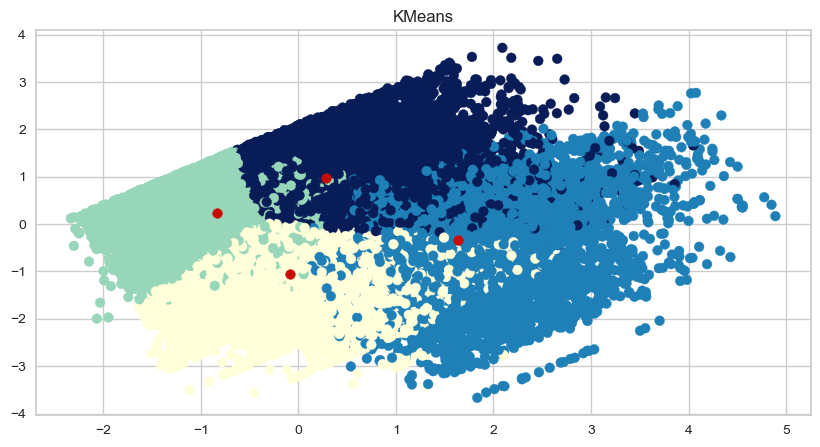

In [72]:
# 
plt.figure(figsize=(10,5))
# KMeans clustering plot
plt.title("KMeans")
plt.scatter(X_pca[:,0],X_pca[:,1],c=kmeans_labels2,cmap='YlGnBu')
plt.scatter(centroids_pca[:,0],centroids_pca[:,1],color='r',marker="o")
plt.show()

## 2.2. Segmentation clients avec DBSCAN

- Contrairement à l'algorithme kMeans, il n'y a pas besoin de définir en amont le nombre de clusters. 

- Un autre avantage de DBSCAN est qu'il permet aussi de gérer les valeurs aberrantes ou anomalies.

Une méthode simple pour optimiser le paramètre **epsilon** d'un modèle DBSCAN consiste à regarder pour chaque observation à quelle distance se situe son voisin le plus proche. Ensuite il suffit de fixer un **epsilon** tel qu'une part "suffisamment grande" des observations ait une distance à son plus proche voisin inférieure à epsilon. Nous allons choisir un epsilon de tel sorte que la plupart des observations aient une distance au proche voisin inférieure à epsilon.

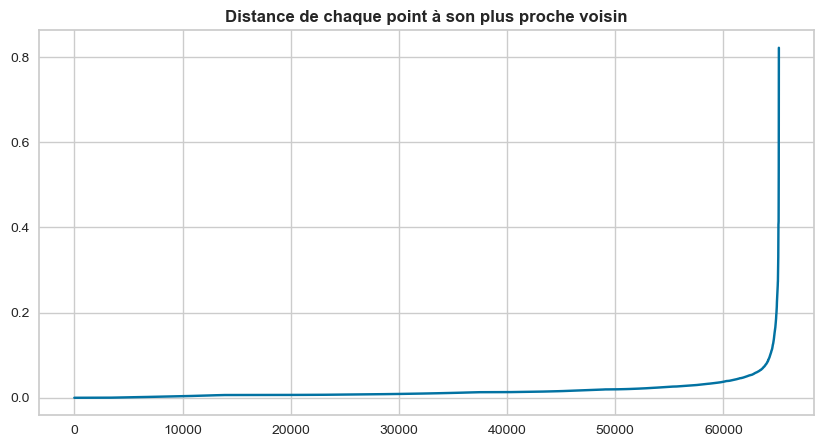

In [74]:
from sklearn.neighbors import NearestNeighbors

plt.figure(figsize=(10, 5))
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.title("Distance de chaque point à son plus proche voisin",fontweight="bold")
plt.show()

- On va essayer eps = 0.2 et eps=0.4. 

**2.2.1: DBSCAN premier essai(eps=0.2**)

In [75]:
# DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

# Instantiate and fit the clustering model  
dbscan1 = DBSCAN(eps=0.2,min_samples=100)
dbscan1.fit(X_scaled)

DBSCAN(eps=0.2, min_samples=100)

In [76]:
# DBSCAN clusters
np.unique(dbscan1.labels_)

array([-1,  0,  1,  2,  3], dtype=int64)

In [77]:
# Make cluster column
dbscan_labels1 = dbscan1.labels_
dbscan_df1 = clustering_data.copy()
dbscan_df1["Cluster"] = dbscan_labels1

# centroids' caracteristics
dbscan_df1.groupby("Cluster").mean()

,Recency,Montant,mean_review_score
Cluster,,,
-1,287.175427,293.047454,2.921113
0,227.349538,123.702740,4.999996
1,210.842760,108.427379,4.000000
2,202.720017,115.980305,1.000000
3,196.454030,100.271761,2.999905


- Les clusters ont une récence assez similaire, dépensent relativement de la même façon mais notent différemment.
- Du point de vu métier, ce clustering n'a pas trop de sens

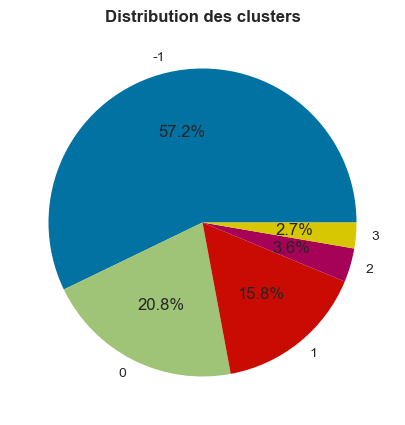

In [81]:
# Proportions of the clusters
cluster_proportions = []
for i in dbscan_df1.Cluster.unique():
    cluster_proportions.append(sum(dbscan_df1.Cluster == i)/len(dbscan_df1.Cluster))

plt.figure(figsize=(10, 5))
plt.pie(cluster_proportions,labels=np.unique(dbscan_labels1),autopct='%1.1f%%')
plt.title("Distribution des clusters",fontweight="bold")
plt.show()

- Les clusters 2 et 3 sont trop petits par rapport au reste, ce qui confirme que cette segmentation ne semble pas pertinente.

**2.2.2. DBSCAN second essai(eps=0.4)**

In [83]:
# DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

# Instantiate and fit the clustering model  
dbscan2 = DBSCAN(eps=0.4,min_samples=100)
dbscan2.fit(X_scaled)

DBSCAN(eps=0.4, min_samples=100)

In [84]:
# DBSCAN clusters
np.unique(dbscan2.labels_)

array([-1,  0,  1,  2], dtype=int64)

In [85]:
# Make cluster column
dbscan_labels2 = dbscan2.labels_
dbscan_df2 = clustering_data.copy()
dbscan_df2["Cluster"] = dbscan_labels2

# centroids' caracteristics
dbscan_df2.groupby("Cluster").mean()

,Recency,Montant,mean_review_score
Cluster,,,
-1,337.913902,609.445609,2.645947
0,233.325386,139.613642,4.597362
1,222.818387,128.420147,1.000068
2,178.612396,115.535338,1.999692


In [87]:
# centroids' caracteristics
dbscan_df2.groupby("Cluster").median()

,Recency,Montant,mean_review_score
Cluster,,,
-1,358.0,377.03,2.0
0,217.0,98.81,5.0
1,196.0,101.12,1.0
2,183.0,99.20,2.0


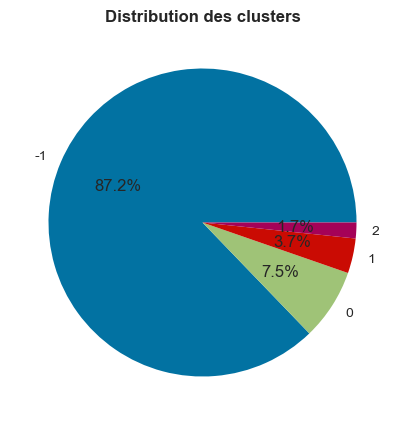

In [88]:
# Proportions of the clusters
cluster_proportions = []
for i in dbscan_df2.Cluster.unique():
    cluster_proportions.append(sum(dbscan_df2.Cluster == i)/len(dbscan_df2.Cluster))

plt.figure(figsize=(10, 5))
plt.pie(cluster_proportions,labels=np.unique(dbscan_labels2),autopct='%1.1f%%')
plt.title("Distribution des clusters",fontweight="bold")
plt.show()

- Les clusters 0, 1 et 2 sont trop petits et la plupart des données sont localisées au cluster **-1**.
- Cette segmentation DBSCAN ne semble pas non plus pertinente.

### 2.3 Sélection du meilleur modèle et exportation du jeu de données pour la simulation

- **D'après tout ce qui précède, notre meilleur modèle est donc le modèle KMeans avec k=4.**

In [92]:
# Joining with the main dataset
merged_data = pd.merge(df_clustering,customer_df,how ="left",on="customer_unique_id")
merged_data = merged_data.rename(columns={"order_purchase_timestamp_x":"order_purchase_timestamp",
                "Montant_x":"Montant","Frequency_x":"Frequency","Recency_x":"Recency"})
merged_data

,customer_unique_id,order_purchase_timestamp,Montant,Frequency,Recency,Recency_score,Frequency_score,Montant_score,rfm_score,rfm_segment,order_purchase_timestamp_y,Montant_y,Frequency_y,mean_review_score,Recency_y,customer_city,customer_state,product_category_name_english
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,141.90,1,111,1,1,3,113,Loyaux,2018-05-10 10:56:27,141.90,1,5.0,111,cajamar,SP,bed_bath_table
1,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,86.22,1,536,4,1,2,412,Perdus,2017-03-10 21:05:03,86.22,1,3.0,536,sao jose,SC,stationery
2,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,43.62,1,320,3,1,1,311,Perdus,2017-10-12 20:29:41,43.62,1,4.0,320,belem,PA,telephony
3,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,196.89,1,287,3,1,4,314,A réactiver,2017-11-14 19:45:42,196.89,1,5.0,287,sorocaba,SP,telephony
4,0004bd2a26a76fe21f786e4fbd80607f,2018-04-05 19:33:16,166.98,1,145,2,1,3,213,Loyaux,2018-04-05 19:33:16,166.98,1,4.0,145,sao paulo,SP,garden_tools
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65124,fff96bc586f78b1f070da28c4977e810,2018-08-15 10:26:57,63.42,1,14,1,1,2,112,Nouveaux clients,2018-08-15 10:26:57,63.42,1,4.0,14,itu,SP,housewares
65125,fffb09418989a0dbff854a28163e47c6,2017-12-17 19:14:35,73.16,1,254,3,1,2,312,Perdus,2017-12-17 19:14:35,73.16,1,5.0,254,veranopolis,RS,watches_gifts
65126,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,84.58,1,261,3,1,2,312,Perdus,2017-12-10 20:07:56,84.58,1,4.0,261,feira de santana,BA,baby
65127,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,133.69,1,118,2,1,3,213,Loyaux,2018-05-02 15:17:41,133.69,1,5.0,118,bom jesus do norte,ES,watches_gifts


In [93]:
clustering_data_ = merged_data.drop(["order_purchase_timestamp_y","Montant_y","Frequency_y","Recency_y",],axis=1)
clustering_data_

,customer_unique_id,order_purchase_timestamp,Montant,Frequency,Recency,Recency_score,Frequency_score,Montant_score,rfm_score,rfm_segment,mean_review_score,customer_city,customer_state,product_category_name_english
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,141.90,1,111,1,1,3,113,Loyaux,5.0,cajamar,SP,bed_bath_table
1,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,86.22,1,536,4,1,2,412,Perdus,3.0,sao jose,SC,stationery
2,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,43.62,1,320,3,1,1,311,Perdus,4.0,belem,PA,telephony
3,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,196.89,1,287,3,1,4,314,A réactiver,5.0,sorocaba,SP,telephony
4,0004bd2a26a76fe21f786e4fbd80607f,2018-04-05 19:33:16,166.98,1,145,2,1,3,213,Loyaux,4.0,sao paulo,SP,garden_tools
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65124,fff96bc586f78b1f070da28c4977e810,2018-08-15 10:26:57,63.42,1,14,1,1,2,112,Nouveaux clients,4.0,itu,SP,housewares
65125,fffb09418989a0dbff854a28163e47c6,2017-12-17 19:14:35,73.16,1,254,3,1,2,312,Perdus,5.0,veranopolis,RS,watches_gifts
65126,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,84.58,1,261,3,1,2,312,Perdus,4.0,feira de santana,BA,baby
65127,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,133.69,1,118,2,1,3,213,Loyaux,5.0,bom jesus do norte,ES,watches_gifts


In [102]:
# Make cluster column
# kmeans_labels2 

kmeans_df = clustering_data_.copy()
kmeans_df["Cluster"] = kmeans_labels2

cols = ["customer_unique_id","order_purchase_timestamp","Recency","Frequency","Montant",
        "mean_review_score","Cluster","rfm_segment"]
kmeans_df = kmeans_df[cols + [c for c in kmeans_df.columns if c not in cols]]
kmeans_df = kmeans_df.drop("product_category_name_english",axis=1)
kmeans_df

,customer_unique_id,order_purchase_timestamp,Recency,Frequency,Montant,mean_review_score,Cluster,rfm_segment,Recency_score,Frequency_score,Montant_score,rfm_score,customer_city,customer_state
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,111,1,141.90,5.0,3,Loyaux,1,1,3,113,cajamar,SP
1,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,536,1,86.22,3.0,0,Perdus,4,1,2,412,sao jose,SC
2,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,320,1,43.62,4.0,0,Perdus,3,1,1,311,belem,PA
3,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,287,1,196.89,5.0,3,A réactiver,3,1,4,314,sorocaba,SP
4,0004bd2a26a76fe21f786e4fbd80607f,2018-04-05 19:33:16,145,1,166.98,4.0,3,Loyaux,2,1,3,213,sao paulo,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65124,fff96bc586f78b1f070da28c4977e810,2018-08-15 10:26:57,14,1,63.42,4.0,1,Nouveaux clients,1,1,2,112,itu,SP
65125,fffb09418989a0dbff854a28163e47c6,2017-12-17 19:14:35,254,1,73.16,5.0,1,Perdus,3,1,2,312,veranopolis,RS
65126,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,261,1,84.58,4.0,1,Perdus,3,1,2,312,feira de santana,BA
65127,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,118,1,133.69,5.0,3,Loyaux,2,1,3,213,bom jesus do norte,ES


In [104]:
# kmeans_df.to_csv("simulation_data.csv")